**Mounting Google Drive for Dataset**

**Importing Libraries**

In [1]:
import numpy as np
import h5py
import math

from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv3D
from keras.layers import Lambda, Concatenate, MaxPooling2D, Maximum, Add
from keras.initializers import RandomNormal
from keras.optimizers import SGD
from keras.losses import MeanSquaredError
from keras.callbacks import Callback,LearningRateScheduler
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

**util functions**

In [2]:
# Load Dataset from Google Drive
def load_train_dataset():
    """
    Load training dataset from Google Drive
    
    Returns:
    clean_image -- Clean image patches
    clean_image -- Hazy image patches
    transmission_value -- Transmission value which convert clean image to 
                          haze image
    """

    file = "C:/Users/adity/OneDrive/Desktop/211172/Major Project/Aditya/Jupyter Notebooks-20241129T163236Z-001/Jupyter Notebooks/mj.hdf5"

    train_dataset = h5py.File(file, 'r')
    clean_image = np.array(train_dataset['clear_image'][:])
    haze_image = np.array(train_dataset['haze_image'][:])
    transmission_map = np.array(train_dataset['transmission_map'])
    transmission_map_refine = np.array(train_dataset['transmission_map_refine'])
    
    return clean_image, haze_image, transmission_map, transmission_map_refine


# Gaussian Weight Initializtion for layers
weight_init = RandomNormal(mean=0.0, stddev=0.001)


# LearningRate Decay function
def lr_schedule(epoch,lr, logs={}):
    """
    Learning Rate Deacy scheduler

    Arguments:
    epoch -- current epoch number
    lr -- current learning rate
    log -- dictionary storing the logs of training

    Returns:
    lr -- learning rate for next epoch
    """
    
    print('learning_rate:',lr)
    logs.update({'lr': lr})
    if epoch in (49,99):
        return lr*0.5
    else:
        return lr

**Preparing Train Dataset**

In [3]:
clean_image, haze_image, transmission_map, transmission_map_refine = load_train_dataset()

print ("Number of training examples:", clean_image.shape[0])
print ("Clean Image Patch shape:", clean_image.shape)
print ("Haze Image Patch shape:", haze_image.shape)
print ("Transmission Map shape:", haze_image.shape)
print ("Transmission Map Refine shape:", haze_image.shape)

Number of training examples: 60000
Clean Image Patch shape: (60000, 16, 16, 3)
Haze Image Patch shape: (60000, 16, 16, 3)
Transmission Map shape: (60000, 16, 16, 3)
Transmission Map Refine shape: (60000, 16, 16, 3)


In [4]:
residual_input = np.clip(((haze_image/255.0)/np.expand_dims(transmission_map_refine,axis=3)),0,1)
residual_output = np.clip((residual_input-clean_image),0,1)

#### Residual Model

**Designing**

In [5]:
def ResidualBlock(X, iter):
    """
    Implementation of the single block of RNN
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    iter -- integer, used to name layers, depending on current residual block
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Save the input value
    X_shortcut = X
    
    # BATCHNORMALIZATION -> CONV Block
    X = BatchNormalization(axis = 3, name = 'res_batchnorm_' + str(iter))(X)
    X = Conv2D(1, (3, 3), strides = (1,1), padding = 'same', kernel_initializer = weight_init, name = 'res_conv_' + str(iter))(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add(name = 'res_add_'+ str(iter))([X,X_shortcut])
    X = Activation('relu', name = 'res_activation_'+ str(iter))(X)
    
    return X

def ResidualModel(input_shape):
    """
    Implementation of the Model.
    
    Arguments:
    input_shape -- shape of the images of the dataset 
                   (height, width, channels) as a tuple.  

    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = Input(input_shape, name = 'input1')

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv1')(X_input)
    X = Activation('relu', name = 'activation1')(X)

    # X = Conv2D(8, (1, 1), kernel_initializer = weight_init, name='test_conv')(X)

    for i in range(17):
        X = ResidualBlock(X, i)
    
    # CONV BLock
    X = Conv2D(3, (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv2')(X)
    X = Activation('relu', name = 'activation2')(X)

    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name='TransmissionModel')

    return model

**Compiling**

In [6]:
# Create an instance of the ResidualModel class with input shape derived from the residual_input's second dimension
model2 = ResidualModel(residual_input.shape[1:])

# Display a summary of the model's architecture, showing layers, parameters, and shapes
model2.summary()

# Compile the model with the SGD optimizer (learning rate 0.001) and Mean Squared Error loss function
model2.compile(optimizer=SGD(0.001), loss=MeanSquaredError())


C:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "TransmissionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 16, 16, 3)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 16)           448       ['input1[0][0]']              
                                                                                                  
 activation1 (Activation)    (None, 16, 16, 16)           0         ['conv1[0][0]']               
                                                                                                  
 res_batchnorm_0 (BatchNorm  (None, 16, 16, 16)           64        ['activation1[0][0]']         
 alization)                                                                       

**Training**

In [7]:
# Train the model using the fit method:
# - Inputs: residual_input (features) and residual_output (labels/targets).
# - batch_size: 30 samples per batch for gradient updates.
# - epochs: Train the model for 150 complete passes through the dataset.
# - callbacks: Includes a LearningRateScheduler to dynamically adjust the learning rate during training based on a predefined schedule (lr_schedule).
history2 = model2.fit(residual_input, residual_output, batch_size=30, epochs=150, callbacks=[LearningRateScheduler(lr_schedule)])


learning_rate: 0.0010000000474974513
Epoch 1/150

2000/2000 [==============================] - 40s 19ms/step - loss: 2.7435e-07 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 2/150
2000/2000 [==============================] - 37s 19ms/step - loss: 2.7312e-07 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 3/150
2000/2000 [==============================] - 40s 20ms/step - loss: 2.7298e-07 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 4/150
2000/2000 [==============================] - 40s 20ms/step - loss: 2.7278e-07 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 5/150
2000/2000 [==============================] - 38s 19ms/step - loss: 2.7264e-07 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 6/150
2000/2000 [==============================] - 41s 20ms/step - loss: 2.7263e-07 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 7/150
2000/2000 [==============================] - 38s 19ms/step - loss: 2.7263e-07 - lr: 0.0010
learning_rate: 0.00

**Generating Models and Graph**

In [11]:
pip install pydot graphviz


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# Visualize the architecture of the model and save it as 'res_model.png'.
# This will generate a diagram showing the model layers and connections.
plot_model(model2, 'res_model.png')

# Visualize the model architecture with additional details like input and output shapes,
# and save the diagram as 'res_model_shape.png'.
# The third parameter (True) enables showing the shapes in the diagram.
plot_model(model2, 'res_model_shape.png', True)


AttributeError: module 'pydot' has no attribute 'InvocationException'

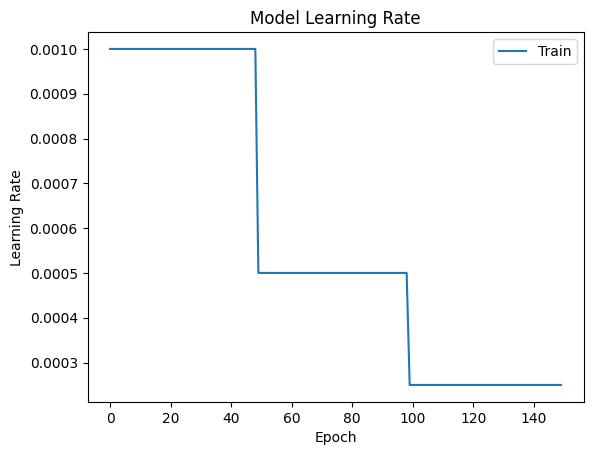

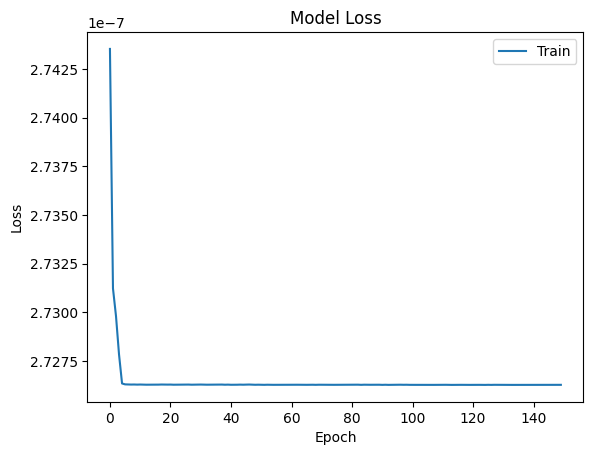

In [13]:
# Plot the learning rate over epochs:
# - history2.history['lr'] contains the learning rate values logged during training.
plt.plot(history2.history['lr'])

# Add a title to the plot for better interpretation.
plt.title('Model Learning Rate')

# Label the y-axis as 'learning rate'.
plt.ylabel('Learning Rate')

# Label the x-axis as 'epoch'.
plt.xlabel('Epoch')

# Add a legend indicating that the data corresponds to the training phase.
plt.legend(['Train'], loc='upper right')

# Save the learning rate plot as an image file named 'res150-30-lr.png'.
plt.savefig('res150-30-lr.png')

# Display the learning rate plot on the screen.
plt.show()

# Plot the training loss over epochs:
# - history2.history['loss'] contains the loss values logged during training.
plt.plot(history2.history['loss'])

# Add a title to the plot for better interpretation.
plt.title('Model Loss')

# Label the y-axis as 'loss'.
plt.ylabel('Loss')

# Label the x-axis as 'epoch'.
plt.xlabel('Epoch')

# Add a legend indicating that the data corresponds to the training phase.
plt.legend(['Train'], loc='upper right')

# Save the loss plot as an image file named 'res150-30-loss.png'.
plt.savefig('res150-30-loss.png')

# Display the loss plot on the screen.
plt.show()


In [ ]:
model2.save('resmodel_150_30.h5')
model2.save_weights('resmodel_150_30_weights.h5')

**Predicting**

1/1 [==============================] - 0s 434ms/step


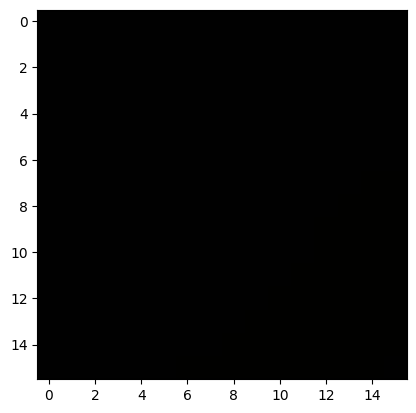

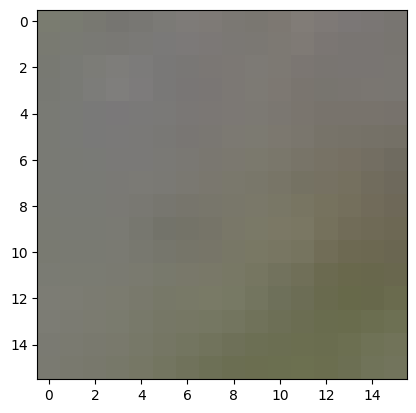

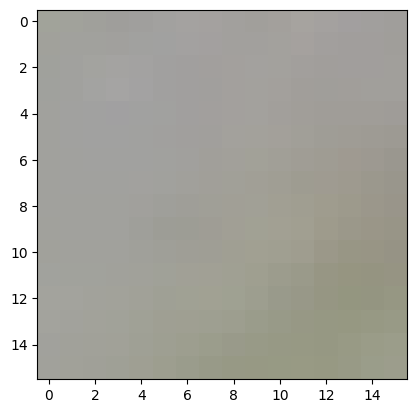

In [14]:
# Expand the dimensions of the 8th residual_input sample (index 7) to create a batch with a single sample.
# This is necessary because the model expects input in batch format (batch_size, height, width, channels).
t = np.expand_dims(residual_input[7], axis=0)

# Use the trained model (model2) to predict the residual (T) for the sample.
# The output T corresponds to the model's prediction for the input sample.
T = model2.predict(t)

# Visualize the difference between the original residual input (residual_input[7]) and the predicted residual (T[0]).
# This can help assess how well the model approximates the residual.
plt.imshow(residual_input[7] - T[0])
plt.show()

# Visualize the corresponding clean image (clean_image[7]) for reference.
# This is the ground truth image that the model aims to help reconstruct.
plt.imshow(clean_image[7])
plt.show()

# Visualize the corresponding hazy image (haze_image[7]) for reference.
# This is the input image to the model before processing.
plt.imshow(haze_image[7])
plt.show()
